In [83]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from scipy import stats
import math

base_path = 'data/project/'

In [84]:
def read(file_name,base_path=base_path):
    return pd.read_csv(f'{base_path}/{file_name}')

def provideStats(df, *, columns = None, confidence=0.95):
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns[1:]
    else:
        cols = pd.Index(columns)

    if len(cols) == 0:
        raise ValueError("No numeric columns to summarise.")

    out_rows = []
    for col in cols:
        s = df[col].dropna()
        n = len(s)
        if n == 0:
            # no data: fill with NaNs
            out_rows.append((np.nan, np.nan, np.nan, np.nan))
            continue

        mean     = s.mean()
        var      = s.var(ddof=1)             # sample variance
        ci_low, ci_high = st.t.interval(
            confidence, n - 1, loc=mean, scale=st.sem(s, nan_policy="omit")
        )
        out_rows.append((mean, var, ci_low, ci_high))

    result = pd.DataFrame(
        out_rows,
        index=cols,
        columns=["mean", "variance", "ci_lower", "ci_upper"],
    )

    return result

def plotData(df, *, close_existing=True):

    if close_existing:
        plt.close('all')           # prevents accidental “ghost” figures

    # keep only numeric columns (strings, categoricals, objects are ignored)
    cols = [c for c in df.columns if is_numeric_dtype(df[c])][1:]
    if not cols:
        raise ValueError("No numeric columns to plot.")

         # one figure, one set of axes
    plt.figure(figsize=(10,6))
    for col in cols:
        plt.plot(df.index, df[col], label=col,)

    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plotCorrelation(df, *, close_existing=True, title=''):
    if close_existing:
        plt.close('all')

    # isolate numeric columns
    num_cols = [c for c in df.columns if is_numeric_dtype(df[c])][1:]
    if len(num_cols) < 2:
        raise ValueError("Need at least two numeric columns to compute correlations.")

    # --- 1. Correlation heat-map -------------------------------------------
    corr = df[num_cols].corr()
    fig_hm, ax_hm = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax_hm)
    ax_hm.set_title(f"Correlation matrix for {title}")
    fig_hm.tight_layout()

    # --- 2. Pair-plot with regression lines ---------------------------------
    pairplot = sns.pairplot(df[num_cols], kind="reg", diag_kind="kde", corner=True)
    pairplot.fig.suptitle(f'Pairplot for {title}', y=1.02)

    # --- 3. QQ plots for each column vs. Normal -----------------------------
    n = len(num_cols)
    n_cols = math.ceil(math.sqrt(n))
    n_rows = math.ceil(n / n_cols)
    fig_qq, axes = plt.subplots(n_rows, n_cols,
                                figsize=(4 * n_cols, 4 * n_rows),
                                squeeze=False)

    for i, col in enumerate(num_cols):
        r, c = divmod(i, n_cols)
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[r][c])
        axes[r][c].set_title(f"QQ plot: {col}")

    # remove any leftover empty axes
    for j in range(i + 1, n_rows * n_cols):
        r, c = divmod(j, n_cols)
        fig_qq.delaxes(axes[r][c])

    fig_qq.suptitle(f"QQ plots vs. Normal distribution for {title}", y=1.02)
    fig_qq.tight_layout()

    # --- Show everything ----------------------------------------------------
    plt.show()

In [85]:
def plotPartialCorrelation(df, *, n_bootstraps=1000, alpha=0.05, close_existing=True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pandas.api.types import is_numeric_dtype
    import pingouin as pg

    if close_existing:
        plt.close('all')

    # Select numeric columns, skip index
    num_cols = [c for c in df.columns if is_numeric_dtype(df[c])][1:]
    if len(num_cols) < 2:
        raise ValueError("Need at least two numeric columns for partial correlation.")

    data = df[num_cols].dropna()
    n_vars = len(num_cols)
    corr_matrix = pd.DataFrame(np.eye(n_vars), index=num_cols, columns=num_cols)
    ci_lower = pd.DataFrame(np.nan, index=num_cols, columns=num_cols)
    ci_upper = pd.DataFrame(np.nan, index=num_cols, columns=num_cols)
    annot_matrix = pd.DataFrame('', index=num_cols, columns=num_cols)

    # Compute partial correlations and bootstrap CIs
    for i in range(n_vars):
        for j in range(i + 1, n_vars):
            var1, var2 = num_cols[i], num_cols[j]
            covar = [v for k, v in enumerate(num_cols) if k not in (i, j)]

            result = pg.partial_corr(data=data, x=var1, y=var2, covar=covar)
            r = result['r'].values[0]
            corr_matrix.loc[var1, var2] = corr_matrix.loc[var2, var1] = r

            # Bootstrap
            boot_rs = []
            for _ in range(n_bootstraps):
                sample = data.sample(frac=1, replace=True)
                try:
                    boot_r = pg.partial_corr(data=sample, x=var1, y=var2, covar=covar)['r'].values[0]
                    boot_rs.append(boot_r)
                except:
                    continue

            if len(boot_rs) > 10:
                lower = np.percentile(boot_rs, 100 * alpha / 2)
                upper = np.percentile(boot_rs, 100 * (1 - alpha / 2))
                ci_lower.loc[var1, var2] = ci_lower.loc[var2, var1] = lower
                ci_upper.loc[var1, var2] = ci_upper.loc[var2, var1] = upper
                text = f"{r:.2f}\n[{lower:.2f}, {upper:.2f}]"
            else:
                text = f"{r:.2f}\n[NA]"
            annot_matrix.loc[var1, var2] = annot_matrix.loc[var2, var1] = text

    # Diagonal annotations
    for i in range(n_vars):
        var = num_cols[i]
        annot_matrix.loc[var, var] = "1.00\n[–]"

    # Plot heatmap with custom annotations
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        corr_matrix,
        annot=annot_matrix,
        fmt="",
        cmap="coolwarm",
        square=True,
        cbar_kws={'label': 'Partial correlation'},
        linewidths=0.5,
        linecolor='lightgray'
    )
    plt.title("Partial Correlation Matrix with 95% CI")
    plt.tight_layout()
    plt.show()

    return corr_matrix, ci_lower, ci_upper

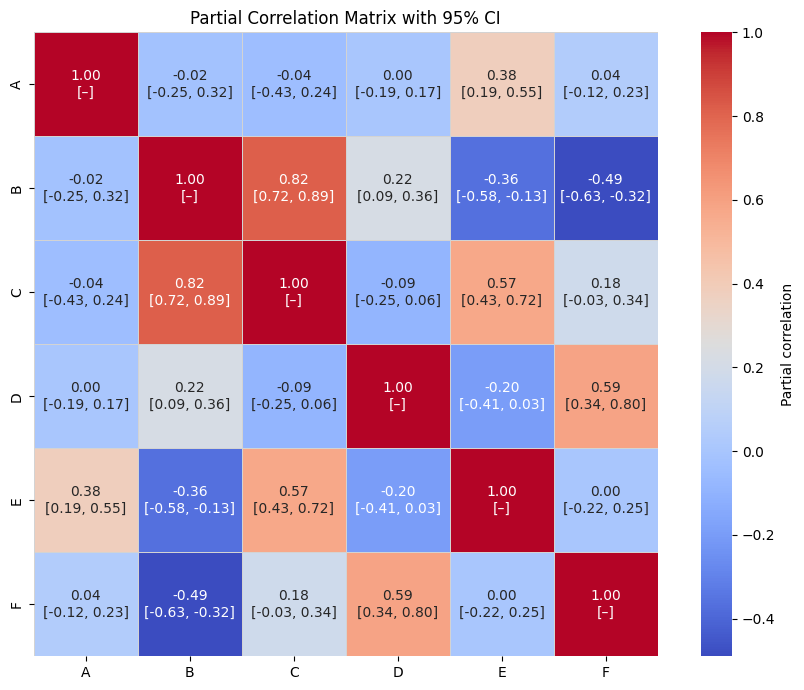

(          A         B         C         D         E         F
 A  1.000000 -0.021146 -0.043526  0.004507  0.380771  0.040975
 B -0.021146  1.000000  0.817309  0.217955 -0.363572 -0.489675
 C -0.043526  0.817309  1.000000 -0.089867  0.570414  0.175654
 D  0.004507  0.217955 -0.089867  1.000000 -0.196334  0.587292
 E  0.380771 -0.363572  0.570414 -0.196334  1.000000  0.001856
 F  0.040975 -0.489675  0.175654  0.587292  0.001856  1.000000,
           A         B         C         D         E         F
 A       NaN -0.249022 -0.430476 -0.194539  0.191101 -0.115357
 B -0.249022       NaN  0.719403  0.086527 -0.578687 -0.628554
 C -0.430476  0.719403       NaN -0.249148  0.427926 -0.026221
 D -0.194539  0.086527 -0.249148       NaN -0.414445  0.338904
 E  0.191101 -0.578687  0.427926 -0.414445       NaN -0.221752
 F -0.115357 -0.628554 -0.026221  0.338904 -0.221752       NaN,
           A         B         C         D         E         F
 A       NaN  0.322191  0.244985  0.169227  0.547228 

In [86]:
plotPartialCorrelation(baseline, n_bootstraps=1000, alpha=0.05, close_existing=True)

## BASELINE

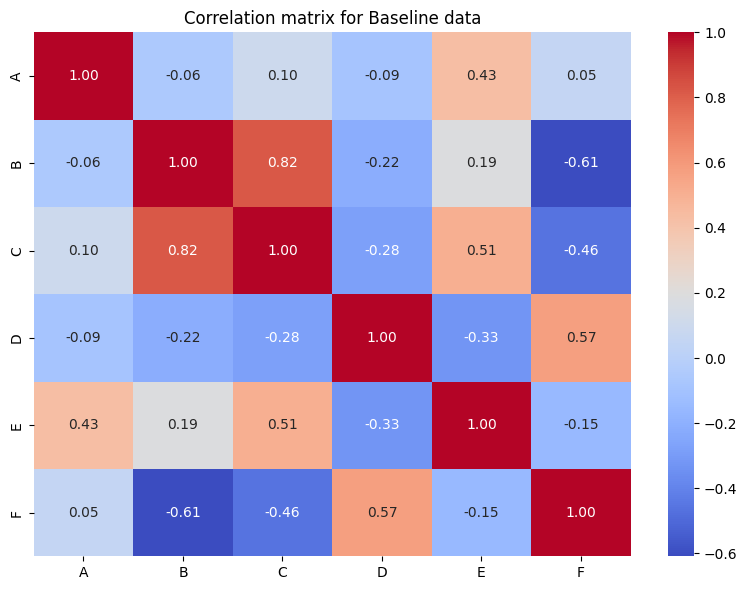

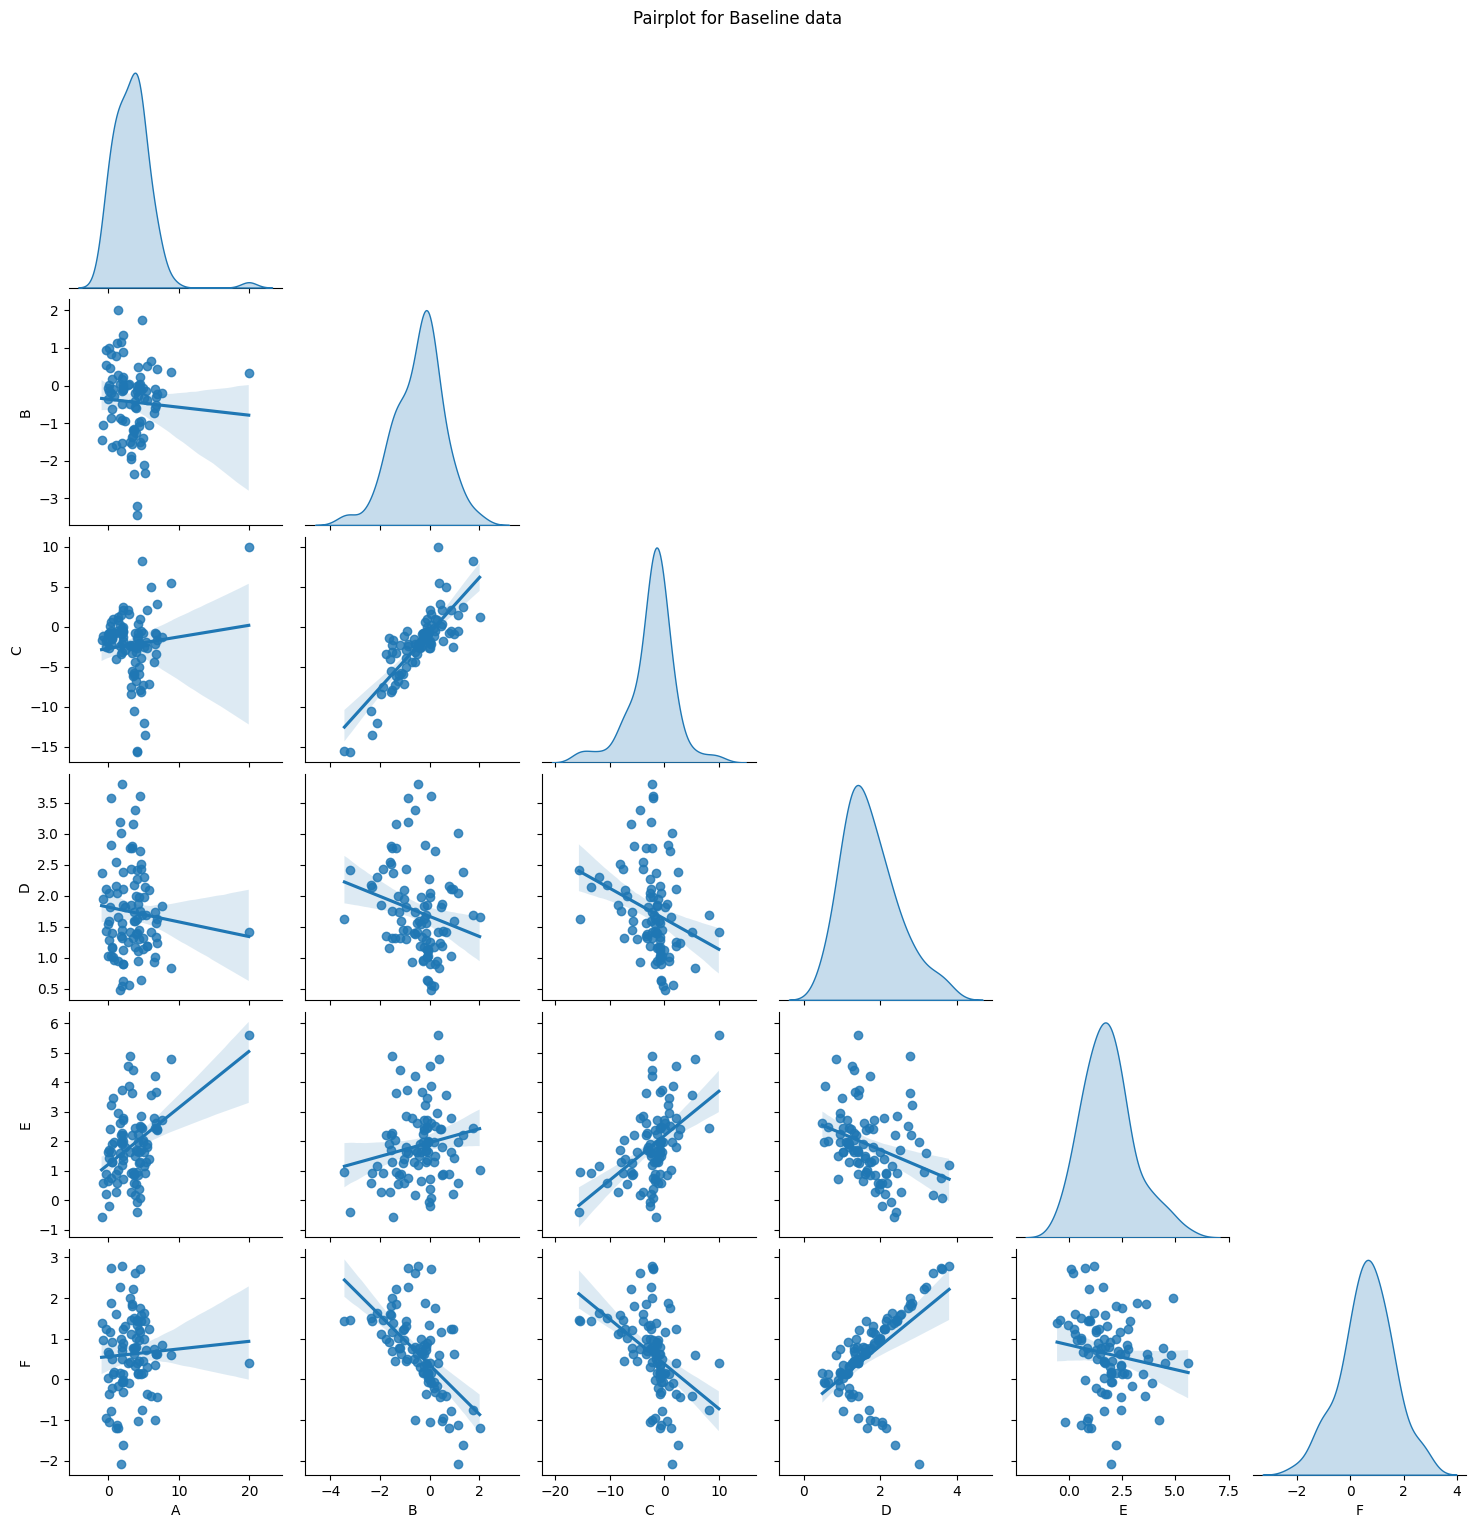

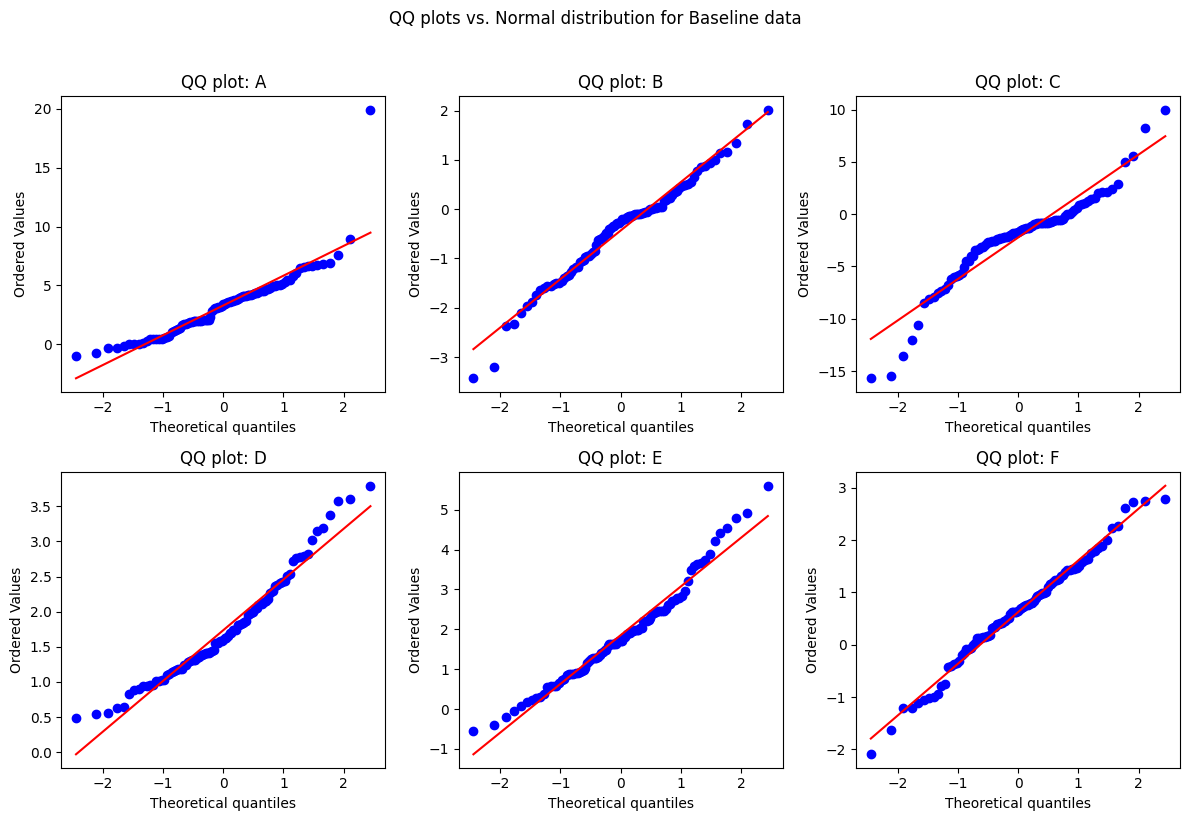

In [87]:
baseline = read('data_1901.csv')

plotCorrelation(baseline, title='Baseline data')

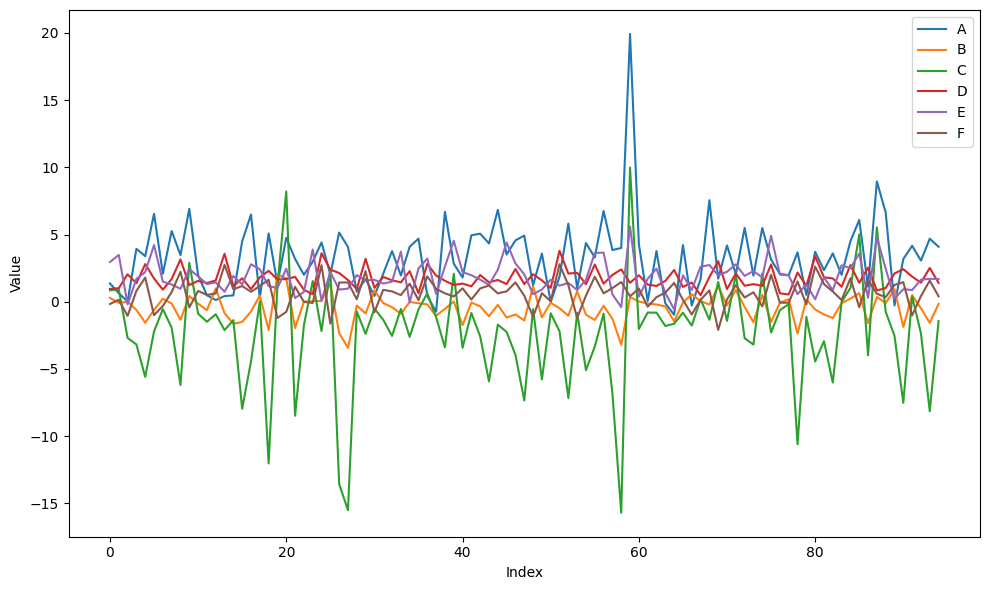

In [88]:
plotData(baseline)

In [89]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [90]:
provideStats(baseline.sample(40, random_state=42))

,mean,variance,ci_lower,ci_upper
A,3.403212,4.235486,2.745022,4.061402
B,-0.553425,0.755825,-0.831467,-0.275383
C,-2.782123,12.864661,-3.929216,-1.635029
D,1.558172,0.341584,1.371255,1.745089
E,2.002888,1.125483,1.663599,2.342176
F,0.568507,0.592248,0.322385,0.814630


## Intervention 1: 40, C=2

In [91]:
intervention1 = read('data_1963.csv')

In [92]:
provideStats(intervention1)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,5.438772,152.328869,1.491558,9.385985
B,-0.273781,1.056087,-0.602443,0.054881
C,2.000000,0.000000,NaN,NaN
D,1.774562,0.344132,1.586949,1.962174
E,1.937574,3.541325,1.335733,2.539416
F,0.617822,0.919881,0.311085,0.924558


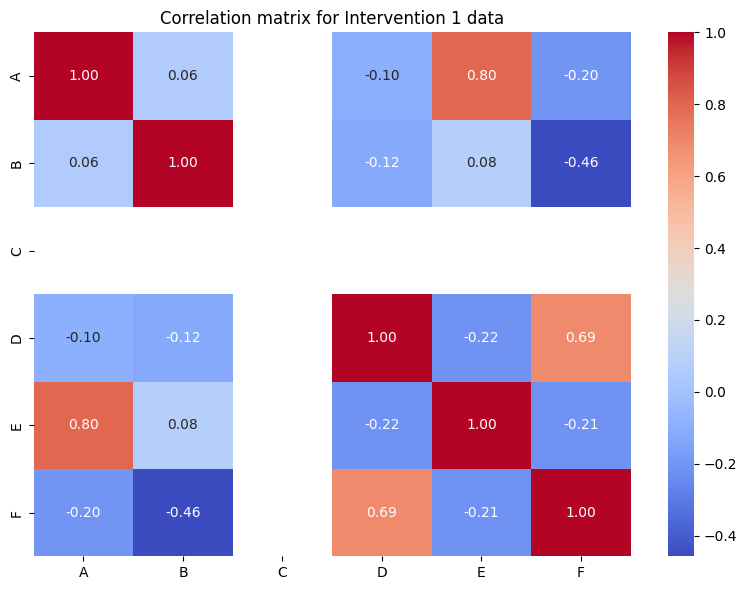

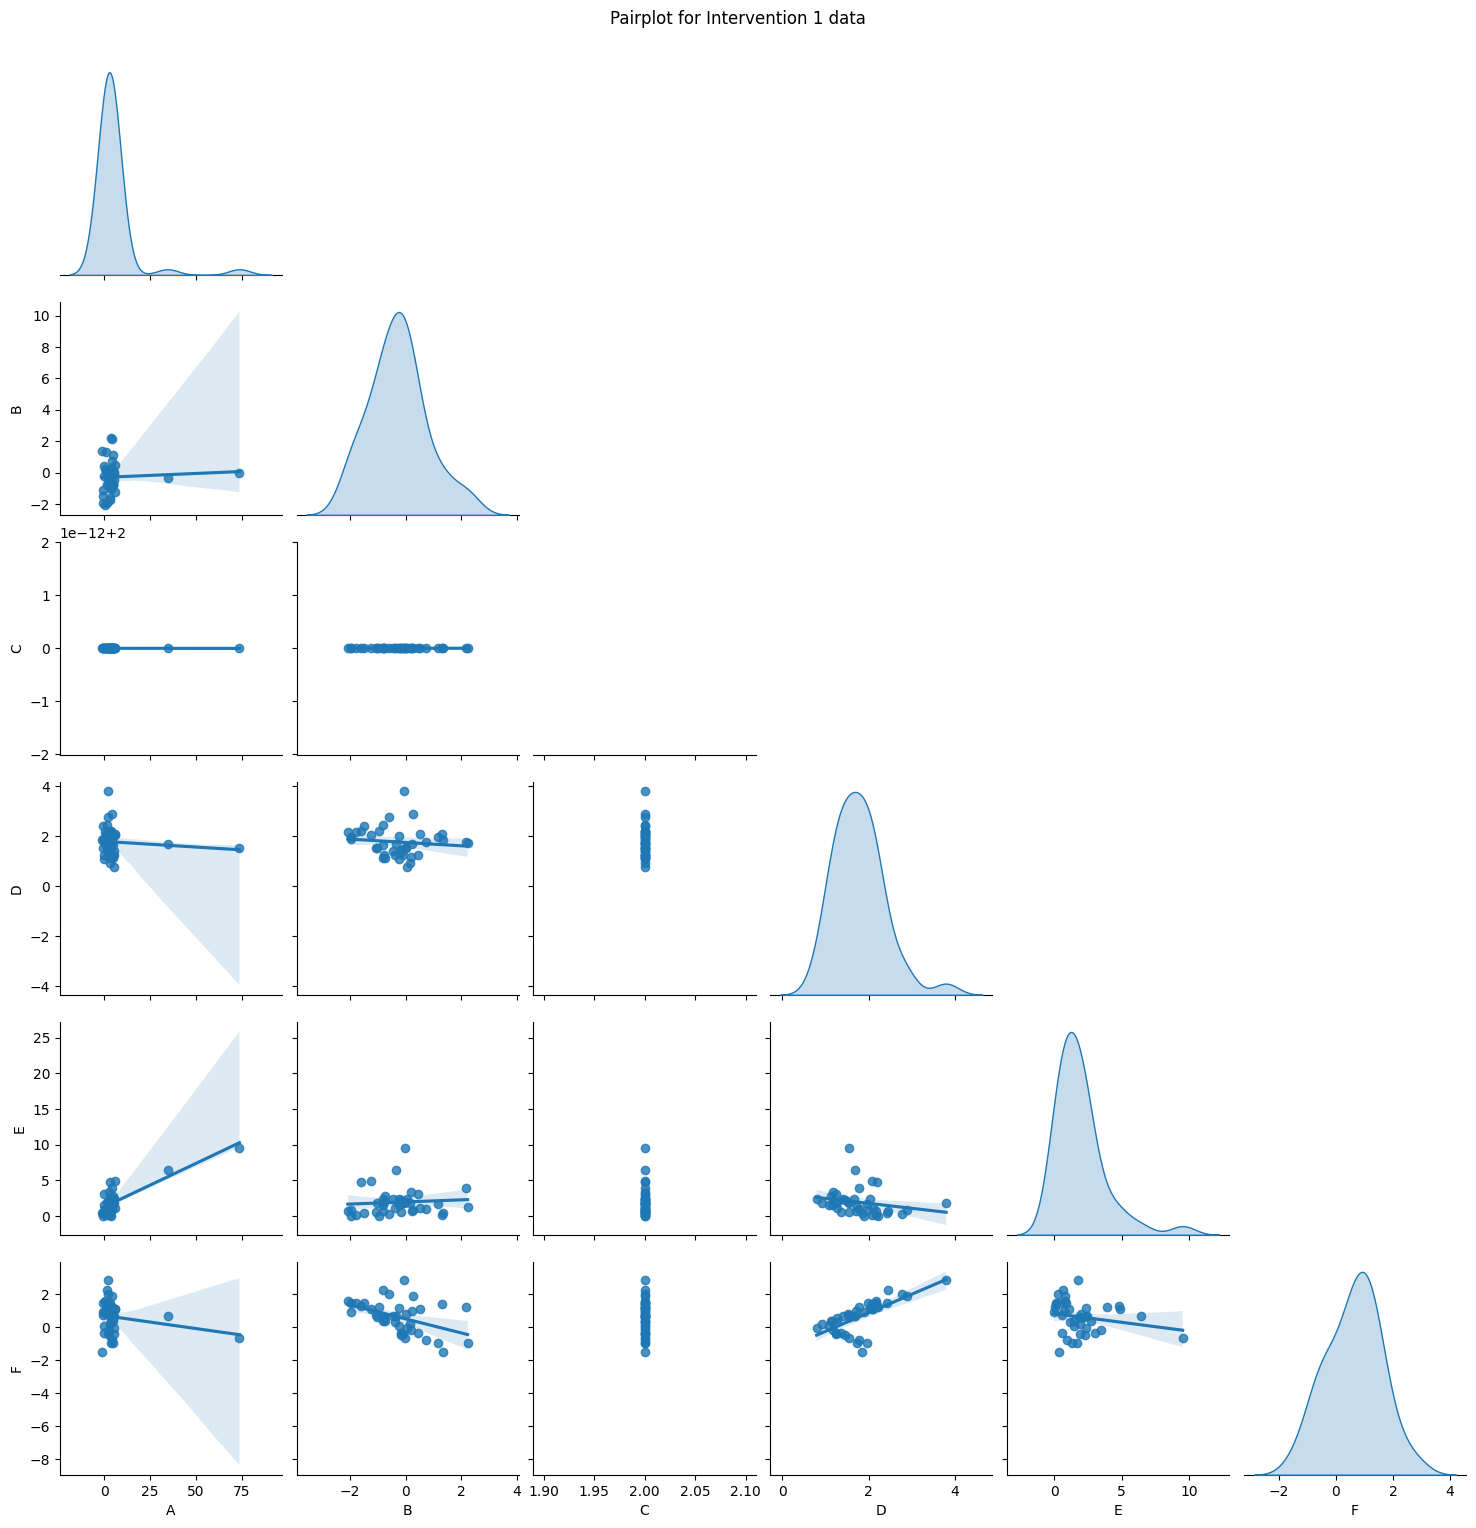

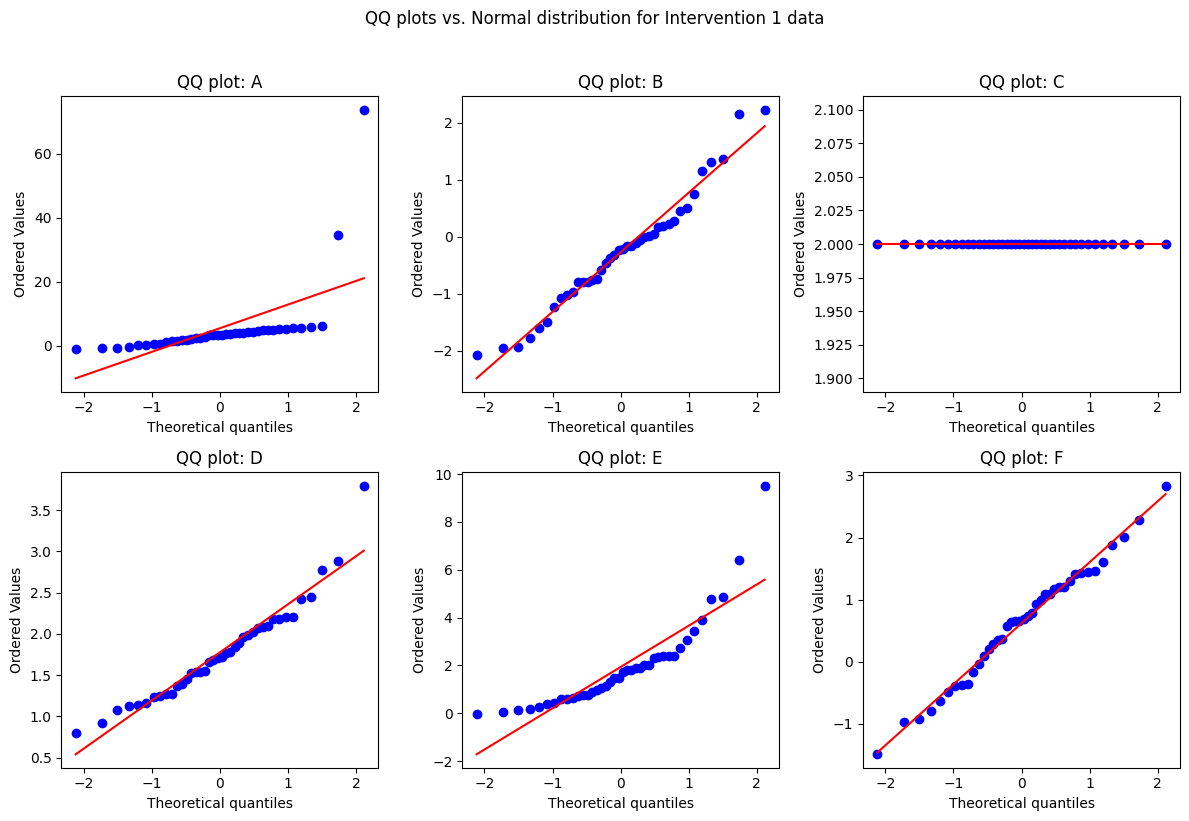

In [93]:
plotCorrelation(intervention1, title='Intervention 1 data')

## Intervention 2: 120, E=-2

In [94]:
intervention2 = read('data_1965.csv')

In [95]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [96]:
provideStats(intervention2)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,3.549203,8.349303,3.026902,4.071505
B,-0.601827,0.873006,-0.770717,-0.432937
C,-6.578707,38.752573,-7.703951,-5.453463
D,1.865239,0.576683,1.727972,2.002506
E,-2.000000,0.000000,NaN,NaN
F,0.865282,0.908282,0.693013,1.037551


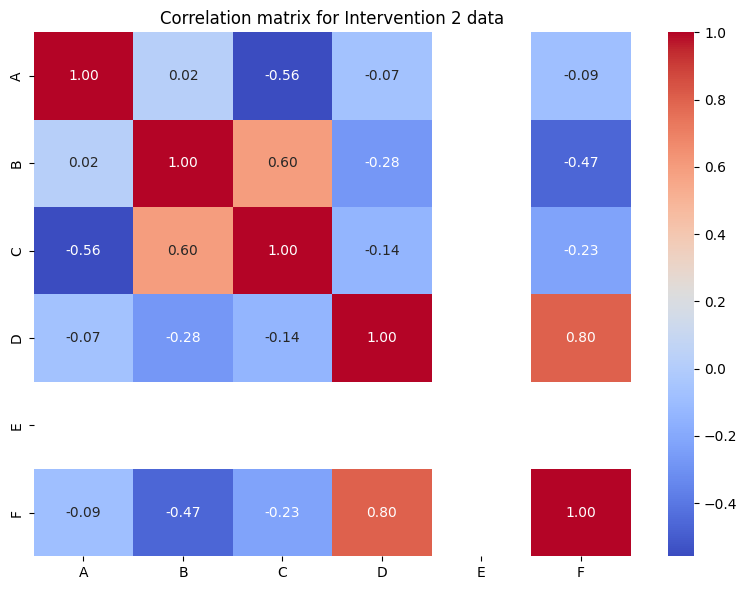

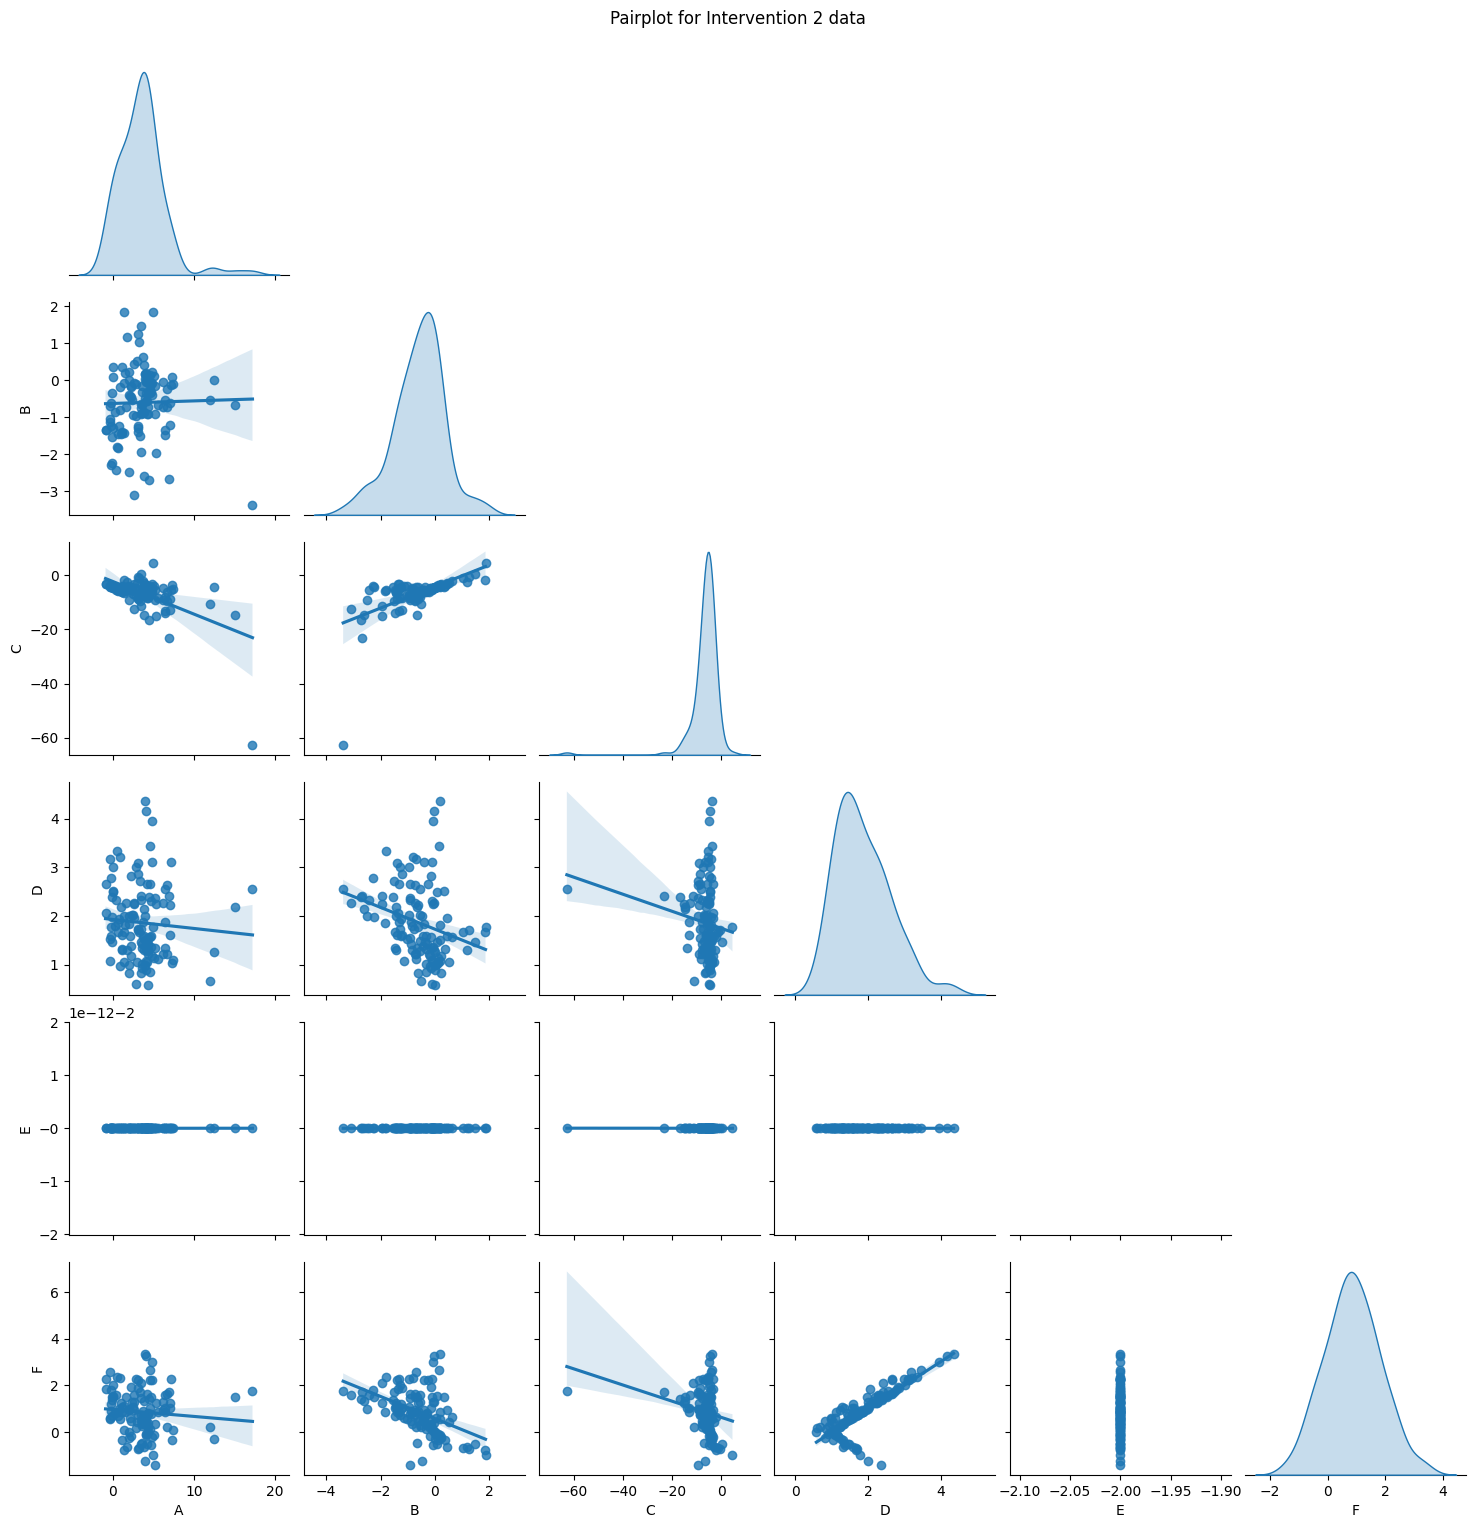

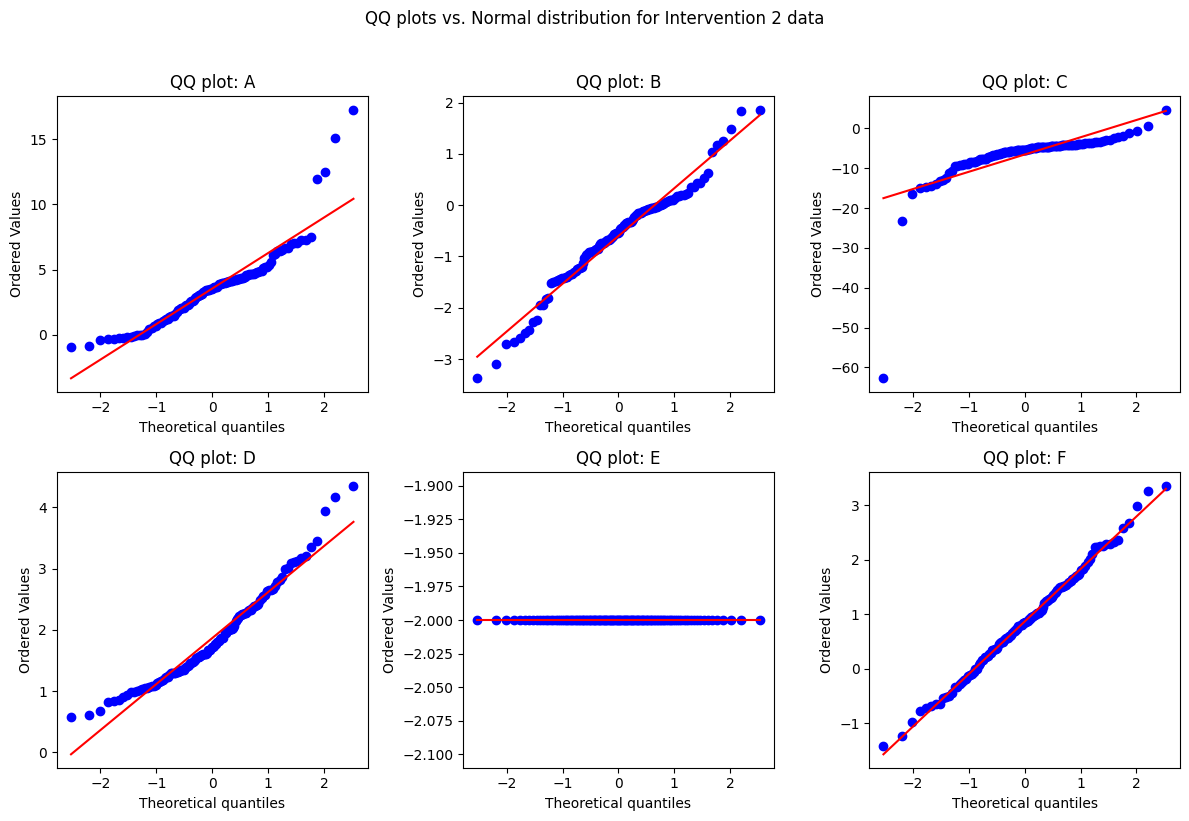

In [97]:
plotCorrelation(intervention2, title='Intervention 2 data')

## Intervention 3: 100, A=-2

In [98]:
intervention3 = read('data_1967.csv')

In [99]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [100]:
provideStats(intervention3)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,-2.000000,0.000000,NaN,NaN
B,-0.502193,0.887690,-0.689141,-0.315246
C,0.155329,4.538151,-0.267367,0.578026
D,1.817026,0.485116,1.678824,1.955227
E,1.650943,1.758163,1.387844,1.914042
F,0.721649,0.884057,0.535084,0.908213


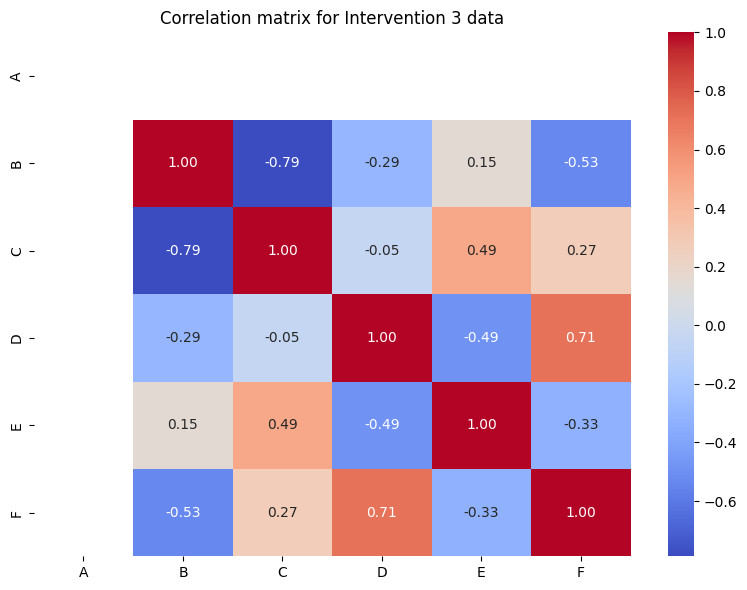

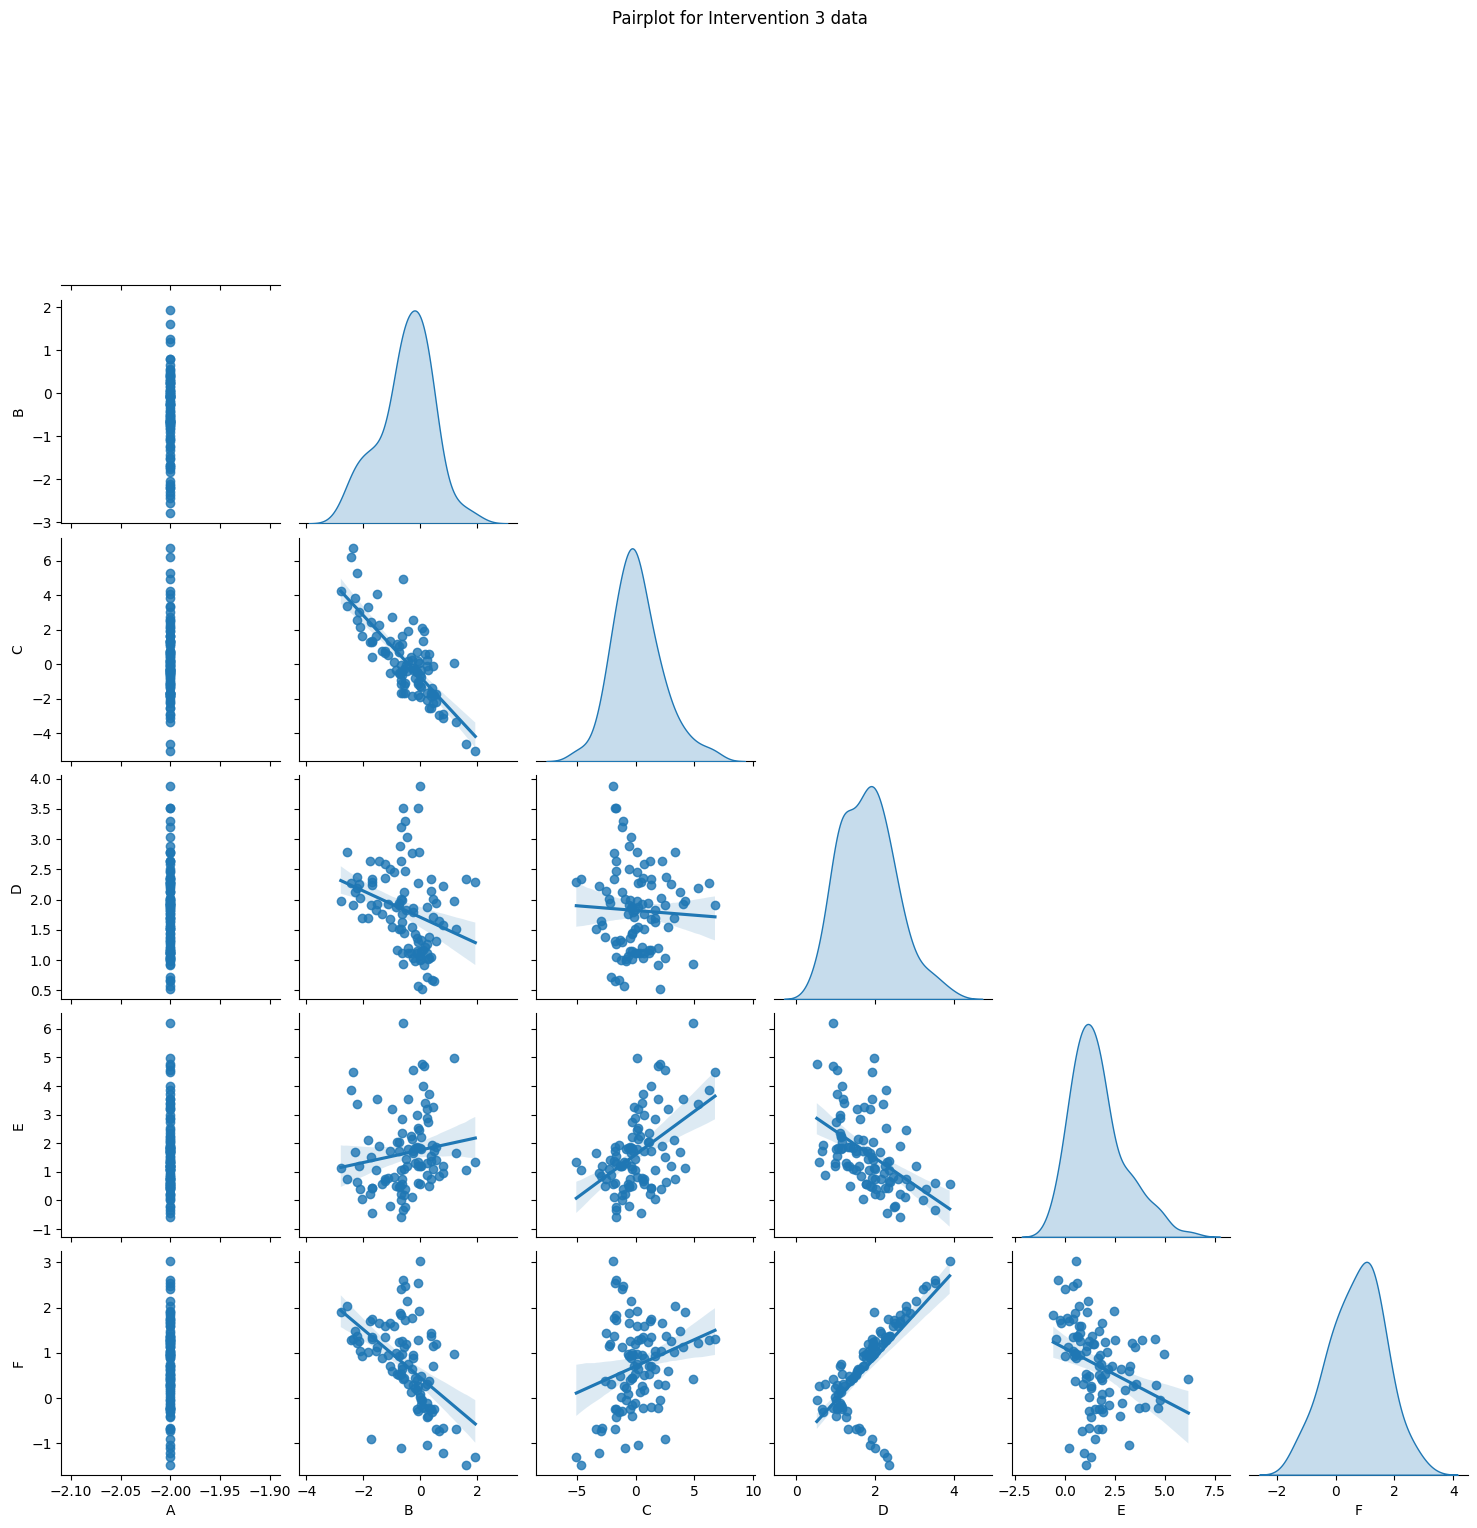

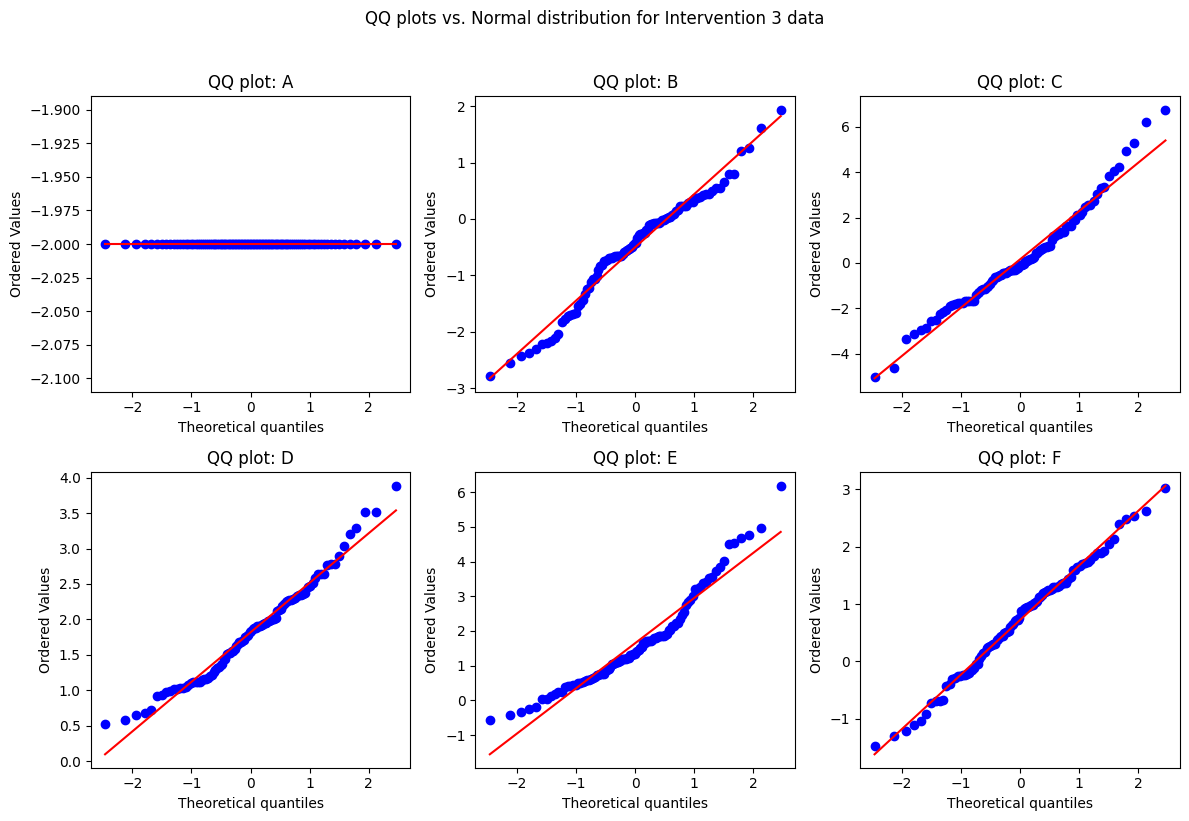

In [101]:
plotCorrelation(intervention3, title='Intervention 3 data')

## Intervention 4: 65, D=-2

In [102]:
intervention4 = read('data_1968.csv')

In [103]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [104]:
provideStats(intervention4)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,3.040803,8.721628,2.309026,3.772580
B,-0.289654,1.099982,-0.549534,-0.029774
C,-2.444746,20.420902,-3.564486,-1.325005
D,-2.000000,0.000000,NaN,NaN
E,1.293744,1.005248,1.045307,1.542181
F,0.583777,1.053600,0.329435,0.838119


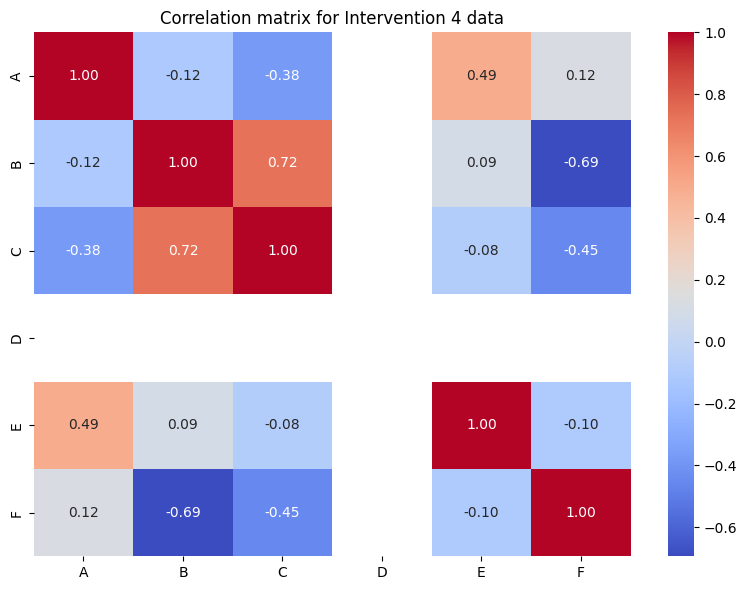

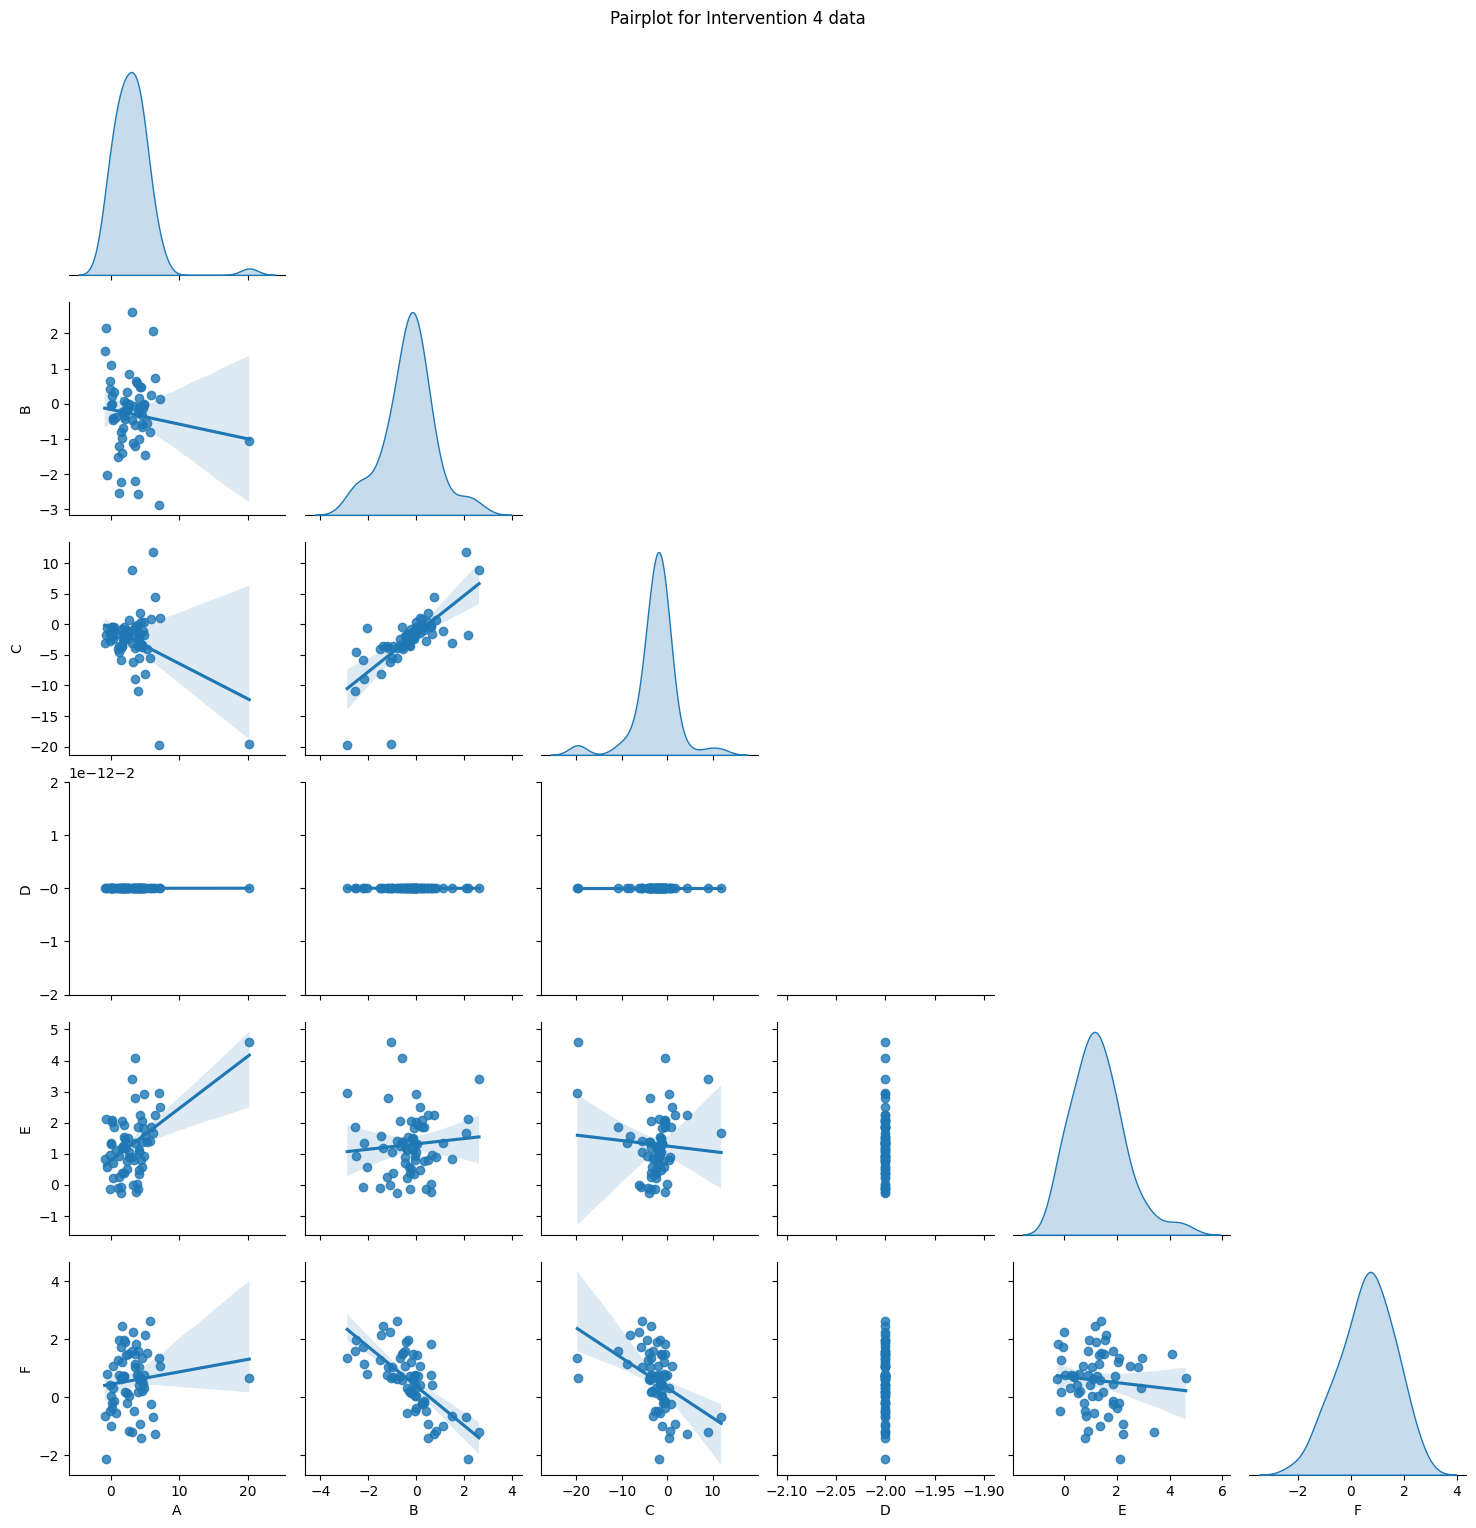

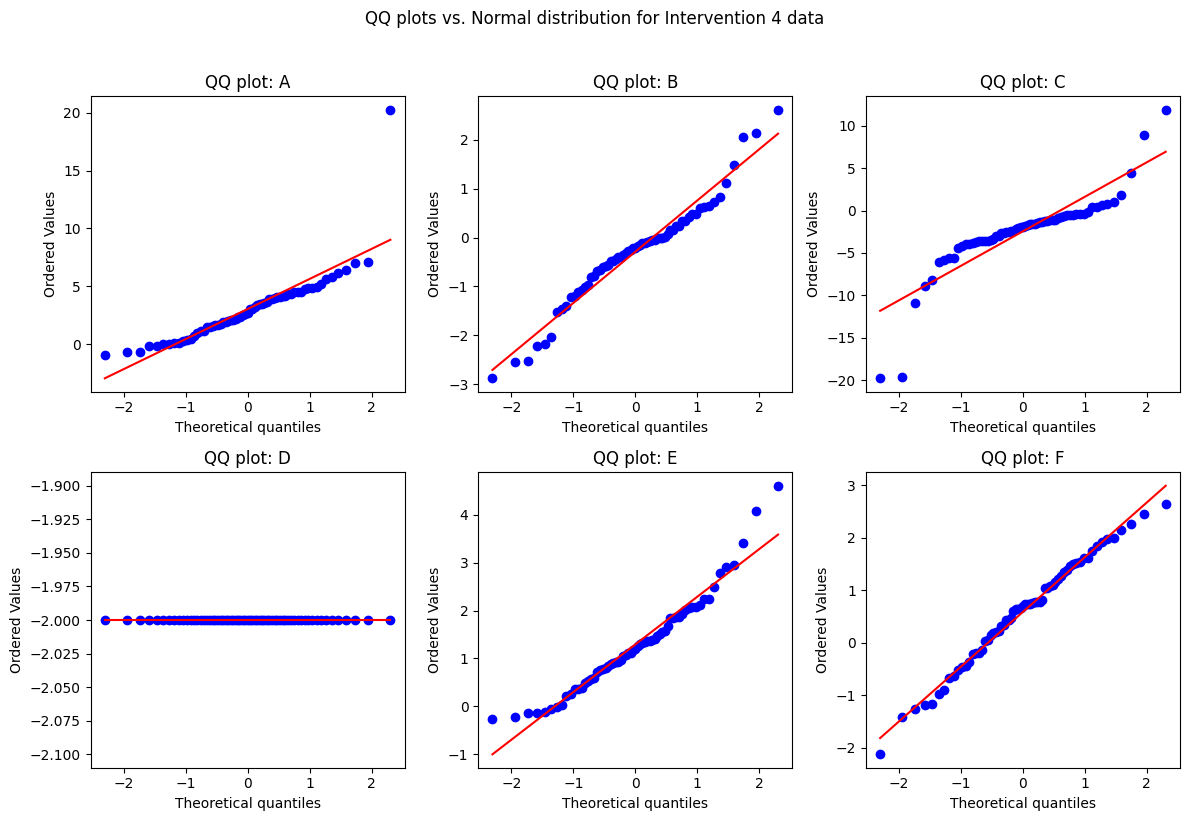

In [105]:
plotCorrelation(intervention4, title='Intervention 4 data')

## Intervention 5: 75, f=-2

In [106]:
intervention5 = read('data_1969.csv')

In [107]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [108]:
provideStats(intervention5)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,3.166867,7.592732,2.532886,3.800848
B,0.797619,1.015440,0.565770,1.029467
C,0.702507,28.846390,-0.533221,1.938235
D,2.825043,0.042716,2.777491,2.872595
E,0.936533,1.205532,0.683913,1.189152
F,-2.000000,0.000000,NaN,NaN


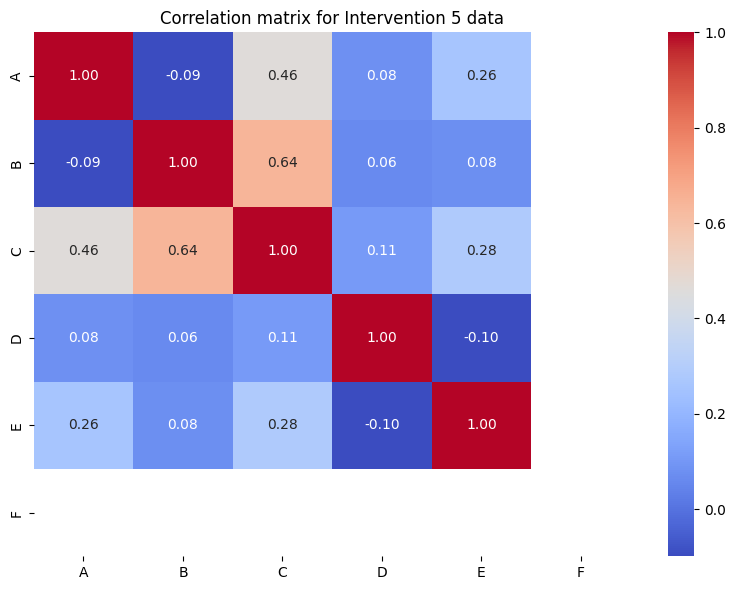

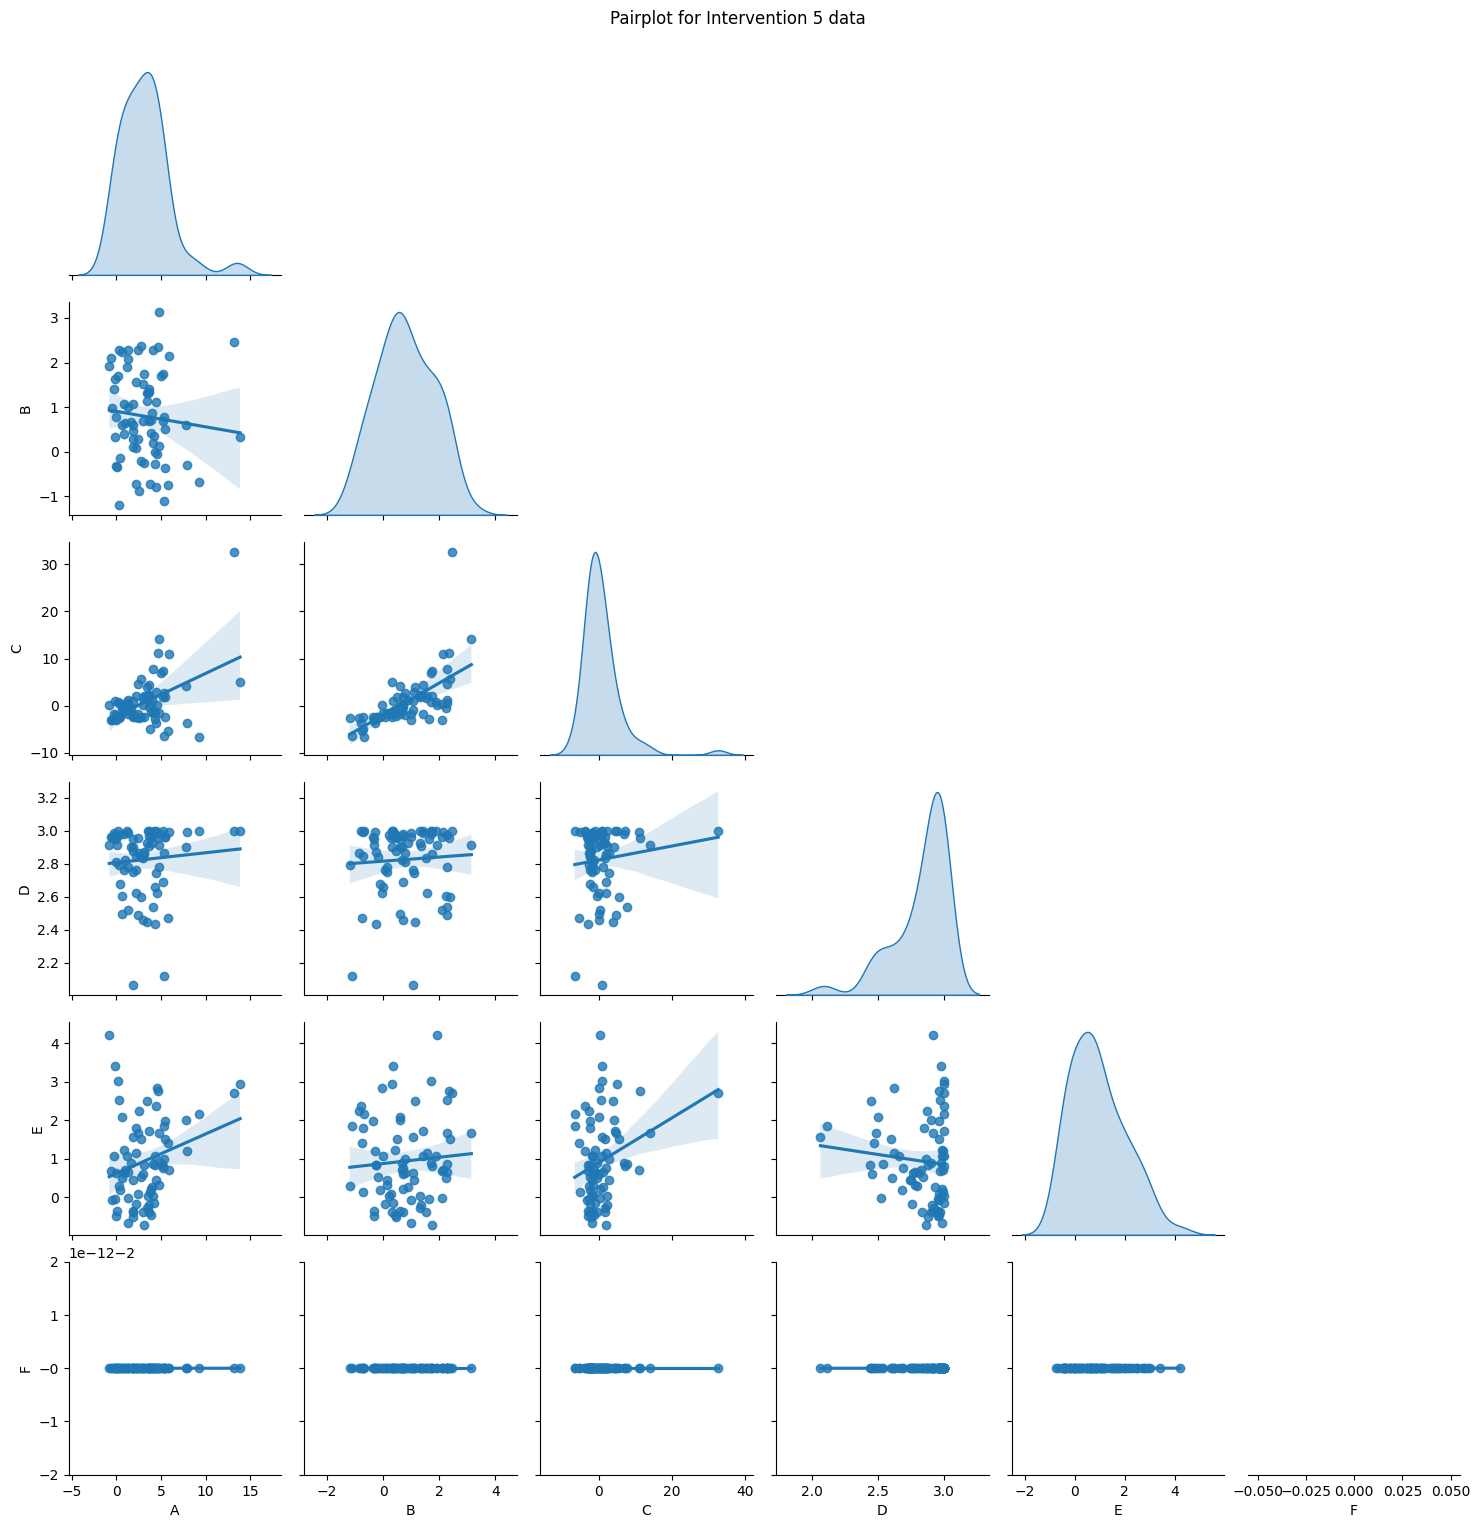

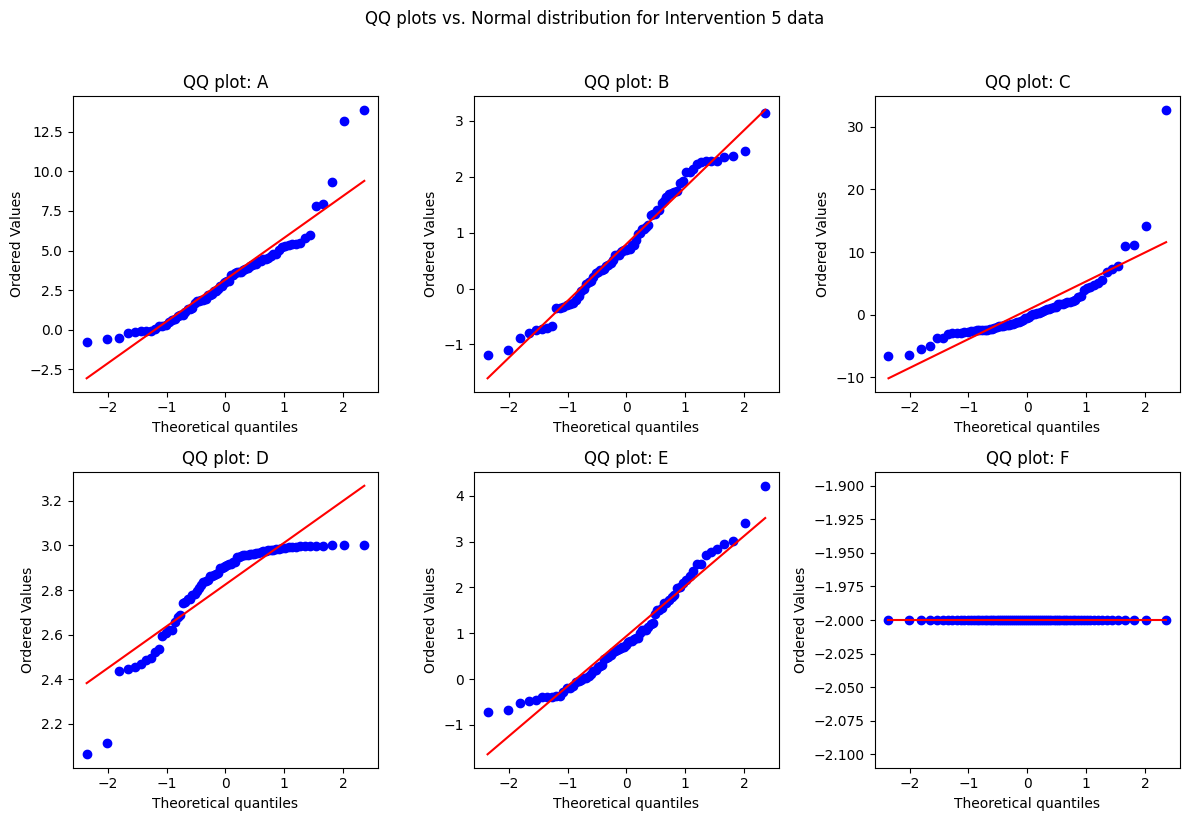

In [109]:
plotCorrelation(intervention5, title='Intervention 5 data')

## Intervention 6: 64,B=2

In [110]:
intervention6 = read('data_1970.csv')

In [114]:
provideStats(baseline)

,mean,variance,ci_lower,ci_upper
A,3.304083,7.548083,2.744413,3.863752
B,-0.433543,0.960889,-0.633230,-0.233856
C,-2.238740,16.837002,-3.074623,-1.402857
D,1.735911,0.527262,1.587991,1.883830
E,1.852564,1.495543,1.603441,2.101686
F,0.623401,0.957952,0.424019,0.822783


In [115]:
provideStats(intervention6)

c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juliu\Miniconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,variance,ci_lower,ci_upper
A,3.116108,5.825097,2.513228,3.718988
B,2.000000,0.000000,NaN,NaN
C,5.649906,29.941213,4.283077,7.016735
D,1.861909,0.669578,1.657509,2.066308
E,1.917690,1.864577,1.576600,2.258781
F,0.845693,0.971164,0.599528,1.091858


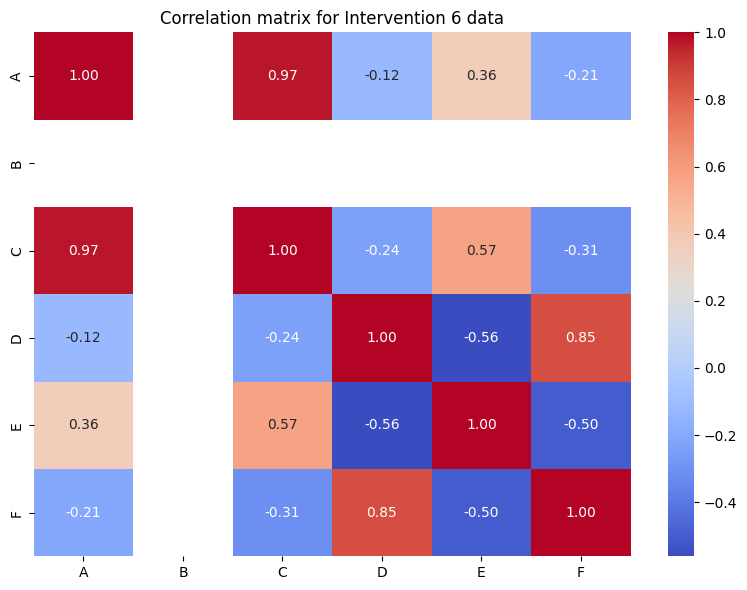

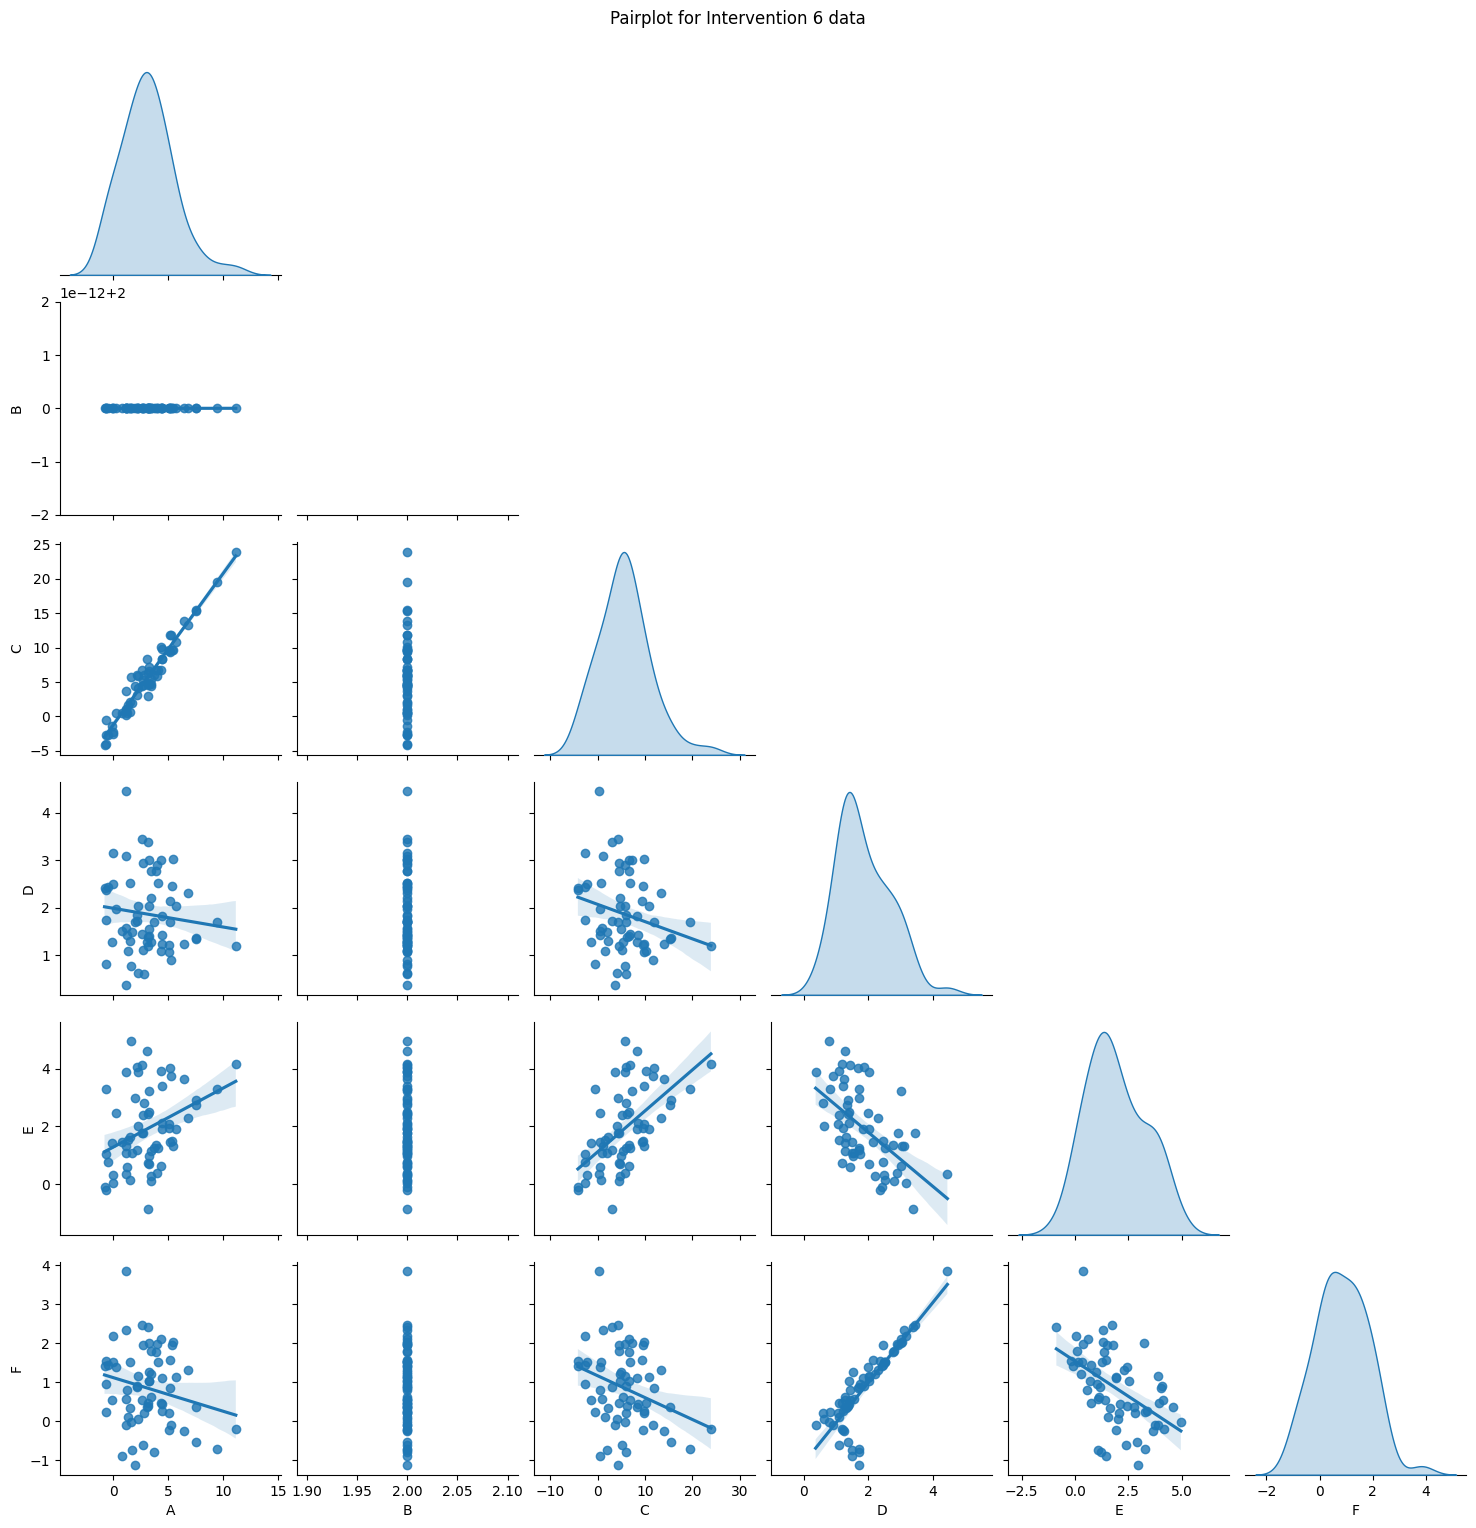

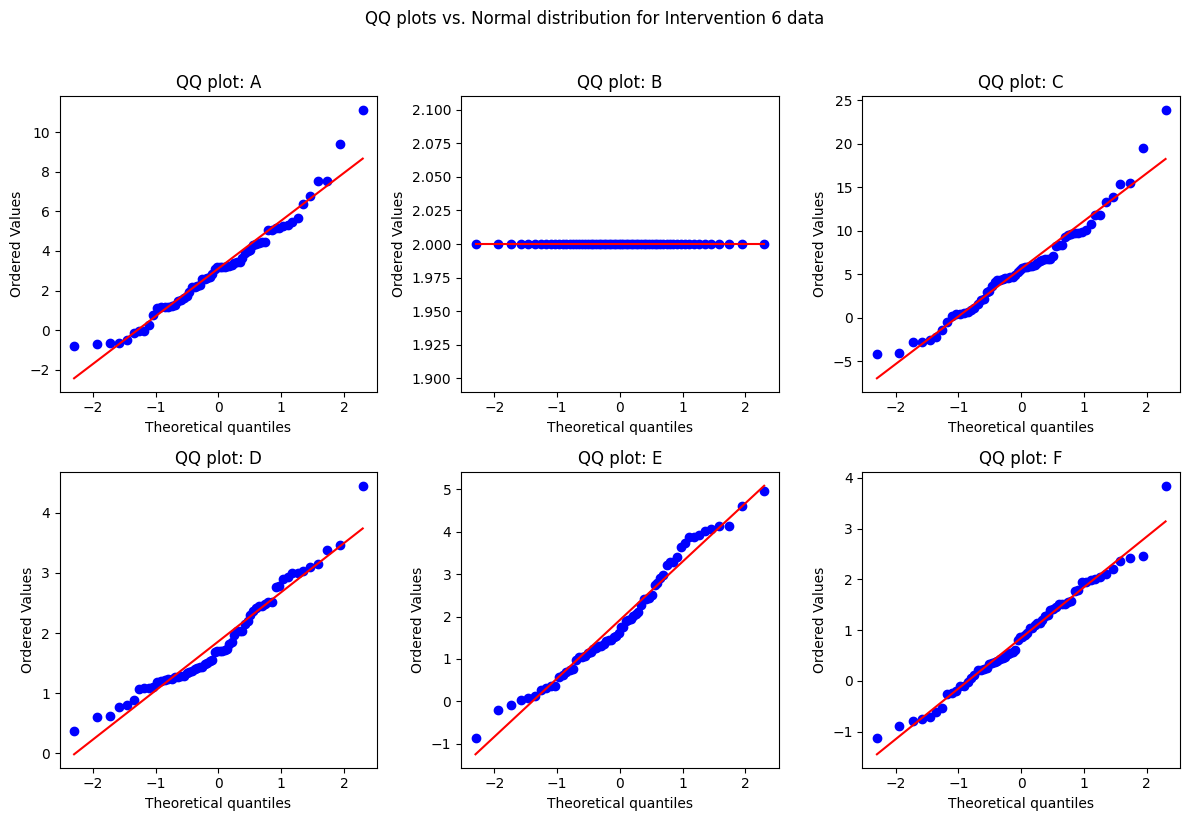

In [113]:
plotCorrelation(intervention6, title='Intervention 6 data')